In [1]:
import numpy as np

# import qutip as qt
import torch
from torch.utils.data import Dataset, DataLoader
import joblib

import torch.nn as nn
import matplotlib.pyplot as plt

from torch import tensor

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
raw_data = joblib.load("raw_data.job").real.swapaxes(1, 2)

In [4]:
class CNNDensityMatrix(nn.Module):
    def __init__(
        self, no_channels, no_filters, kernel_window, timeseries_length
    ):
        super(CNNDensityMatrix, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=no_channels,
            out_channels=no_filters,
            kernel_size=kernel_window,
        )
        # len_output_of_conv1d = timeseries_length - kernel_window + 1
        # self.fc1 = nn.Linear(len_output_of_conv1d * no_filters, no_channels)
        self.fc1 = nn.Linear(no_filters, no_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.fc1(x.permute(0, 2, 1)).permute(0, 2, 1)
        return x


class DensityMatrixDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = (self.X[idx], self.y[idx])
        return sample

In [91]:
N = raw_data.shape[0]
C = raw_data.shape[1]
L = raw_data.shape[2]

no_filters = 1  # 16

kernel_window = 100  # 4


model = CNNDensityMatrix(
    no_channels=C,
    no_filters=no_filters,
    kernel_window=kernel_window,
    timeseries_length=L,
)

model = model.to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


print(model)

CNNDensityMatrix(
  (conv1): Conv1d(4, 1, kernel_size=(100,), stride=(1,))
  (fc1): Linear(in_features=1, out_features=4, bias=True)
)


In [92]:
X_raw = raw_data
y_raw = raw_data[:, :, kernel_window - 1 :]

dataset = DensityMatrixDataset(X_raw, y_raw)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [96]:
num_epochs = 1000  # Number of training epochs

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        X, y_true = data
        X = X.to(device)
        y_true = y_true.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        y_hat = model(X)
        loss = criterion(y_true, y_hat)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:  # Print every 10 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3e}")
            running_loss = 0.0
            if running_loss <= 1e-7:
                break

print("Finished Training")

[1, 10] loss: 3.243e-03
[2, 10] loss: 3.107e-03
[3, 10] loss: 3.024e-03
[4, 10] loss: 2.903e-03
[5, 10] loss: 2.808e-03
[6, 10] loss: 2.752e-03
[7, 10] loss: 2.651e-03
[8, 10] loss: 2.563e-03
[9, 10] loss: 2.474e-03
[10, 10] loss: 2.408e-03
[11, 10] loss: 2.315e-03
[12, 10] loss: 2.285e-03
[13, 10] loss: 2.195e-03
[14, 10] loss: 2.129e-03
[15, 10] loss: 2.055e-03
[16, 10] loss: 2.020e-03
[17, 10] loss: 1.956e-03
[18, 10] loss: 1.910e-03
[19, 10] loss: 1.854e-03
[20, 10] loss: 1.810e-03
[21, 10] loss: 1.734e-03
[22, 10] loss: 1.715e-03
[23, 10] loss: 1.670e-03
[24, 10] loss: 1.639e-03
[25, 10] loss: 1.592e-03
[26, 10] loss: 1.554e-03
[27, 10] loss: 1.514e-03
[28, 10] loss: 1.495e-03
[29, 10] loss: 1.475e-03
[30, 10] loss: 1.436e-03
[31, 10] loss: 1.403e-03
[32, 10] loss: 1.378e-03
[33, 10] loss: 1.364e-03
[34, 10] loss: 1.311e-03
[35, 10] loss: 1.319e-03
[36, 10] loss: 1.302e-03
[37, 10] loss: 1.283e-03
[38, 10] loss: 1.252e-03
[39, 10] loss: 1.222e-03
[40, 10] loss: 1.189e-03
[41, 10] 

KeyboardInterrupt: 

In [97]:
all_true = y_raw

all_preds = model(tensor(X_raw).to(device)).cpu().detach().numpy()

rng = np.random.default_rng(seed=0)

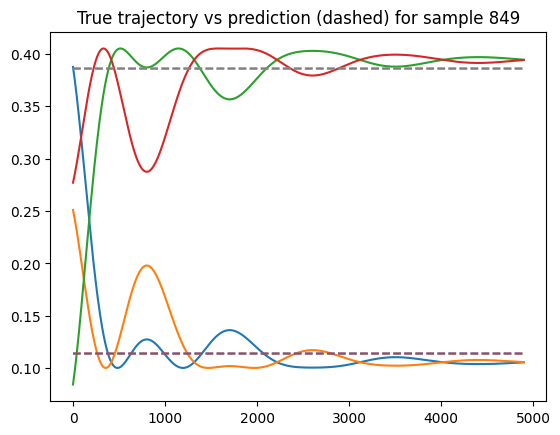

In [98]:
i = rng.integers(0, N - 1)

plt.plot(all_true[i].T)
plt.plot(all_preds[i].T, "--")
plt.title(f"True trajectory vs prediction (dashed) for sample {i}")
plt.show()

In [99]:
import seaborn as sns

In [100]:
conv_weights = model.conv1.weight.clone().detach()

In [101]:
conv_weights -= conv_weights.min()
conv_weights /= conv_weights.max()

<Axes: >

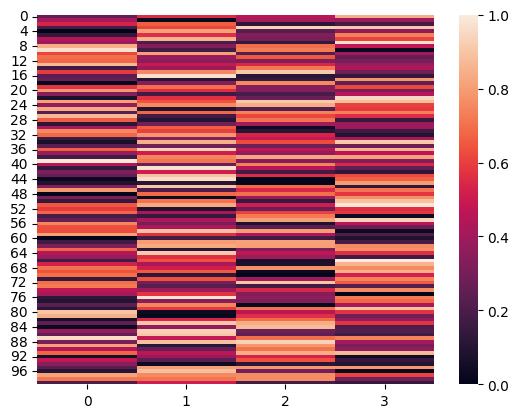

In [102]:
sns.heatmap(conv_weights.mean(0).cpu().numpy().T)

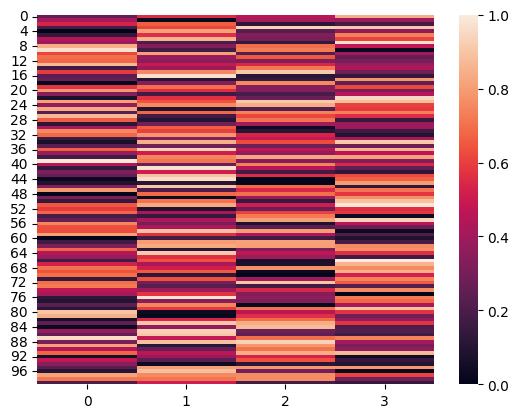

In [103]:
for i in conv_weights:
    sns.heatmap(i.cpu().numpy().T)
    plt.show()